**Process pedestrian JSON file**

In [20]:
%matplotlib inline  
import os
import numpy as np
from PIL import Image
import cv2
from matplotlib.pyplot import figure, imshow, savefig
import matplotlib.pyplot as plt
import collections
import os
import json
import torch
import shutil

In [21]:
fold_dict_filename = 'pedestrian_dataset_folds/fold_dict.json'
fold_dict = json.load(open(fold_dict_filename, 'r'))
num_frames = 30
frames_to_process = set()
for json_filename in fold_dict:
    json_path = os.path.join(fold_dict[json_filename], json_filename)
    ped_json = json.load(open(json_path, 'r'))
    video_name = ped_json['video']
    first_frame = ped_json['frame_data'][0]
    start = first_frame['frame_index']
    for idx in range(start, start + num_frames):
        frames_to_process.add(video_name + '-' + str(idx))

In [22]:
frames_dict = {}
for frame in frames_to_process:
    video, idx = frame.split('-')
    if video not in frames_dict:
        frames_dict[video] = []
    frames_dict[video].append(int(idx))
for video in frames_dict:
    frames_dict[video] = sorted(frames_dict[video])

In [23]:
frames_dict

{'video_0001': [457,
  458,
  459,
  460,
  461,
  462,
  463,
  464,
  465,
  466,
  467,
  468,
  469,
  470,
  471,
  472,
  473,
  474,
  475,
  476,
  477,
  478,
  479,
  480,
  481,
  482,
  483,
  484,
  485,
  486],
 'video_0004': [33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62],
 'video_0005': [11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
 

In [37]:
names_dict = {}
for video in frames_dict:
    if video not in names_dict:
        names_dict[video] = []
    for idx in frames_dict[video]:  
        names_dict[video].append(video + '-' + str(idx))

In [30]:
video_id = 'video_0266'
video_name = os.path.join('clips', video_id + '.mp4')
images = get_video_frames(video_name, frames_dict[video_id])

In [ ]:
for image in enumerate(i, images):
    image_name = names_dict[video_id][i]
    test(image, model, 19, image_name)

**Append features extracted from segmentation mask**

(1080, 1920)
[('road', 0), ('sidewalk', 0), ('traffic_light', 0), ('traffic_sign', 0), ('vehicle', 1)]


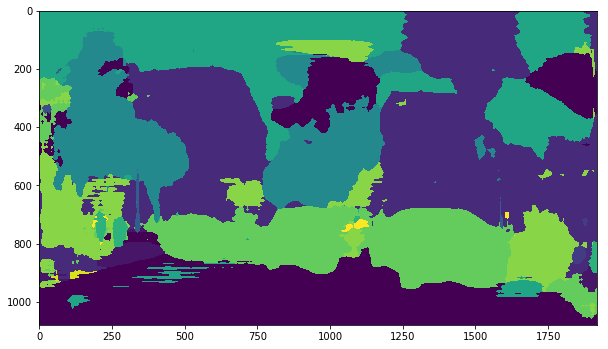

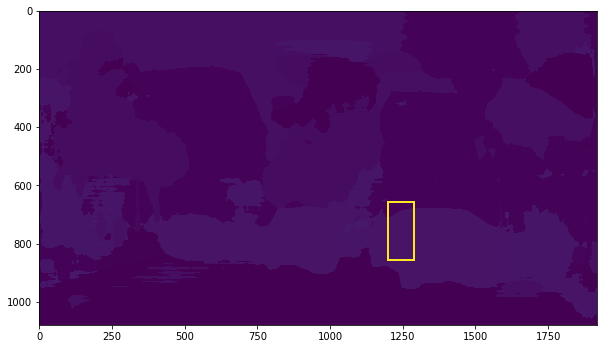

In [210]:
image_filename = 'prediction/video_0225-16.png'
bb_top_left = [1200, 657]
size = [90, 200]
width_limit = 1920
height_limit = 1080
labels = {
    0: 'road', 
    1: 'sidewalk',
    2: 'ignore',
    3: 'ignore',
    4: 'ignore',
    5: 'ignore',
    6: 'traffic_light',
    7: 'traffic_sign',
    8: 'ignore',
    9: 'ignore',
    10: 'ignore',
    11: 'ignore',
    12: 'ignore',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle',
}

convert_id = {
    0: 0,
    1: 1,
    6: 2,
    7: 3,
    13: 4,
    14: 4,
    15: 4,
    16: 4,
    17: 4,
    18: 4
}

our_labels = {
    0: 'road',
    1: 'sidewalk',
    2: 'traffic_light',
    3: 'traffic_sign',
    4: 'vehicle'    
}


def generate_segmentation_features(filename, bb_top_left, size, percent=0.05):
    image = np.array(Image.open(image_filename))
    
    left_x = bb_top_left[0]
    right_x = bb_top_left[0] + size[0]
    if right_x > width_limit:
        right_x = width_limit
    top_y = bb_top_left[1]
    bottom_y = bb_top_left[1] + size[1]
    if bottom_y > height_limit:
        bottom_y = height_limit
        
    tl = [left_x, top_y]
    bl = [left_x, bottom_y]
    tr = [right_x, top_y]
    br = [right_x, bottom_y]
    points = np.array([tl, bl, br, tr], dtype=np.int32)
    line_color = (255, 0, 0)
    figure(figsize=(10, 10))
    imshow(image)
    figure(figsize=(10, 10))
    image = cv2.polylines(image, [points], True, line_color, 5)
    imshow(image)
    histogram = {}
    for bdd_id in labels:
        histogram[bdd_id] = 0
    for y in range(top_y, bottom_y):
        for x in range(left_x, right_x):
            if image[y, x] in histogram:
                histogram[image[y, x]] += 1
    
    our_histogram = {}
    for our_id in our_labels:
        our_histogram[our_id] = 0
    for bdd_id in histogram:
        if labels[bdd_id] == 'ignore':
            continue
        our_histogram[convert_id[bdd_id]] += histogram[bdd_id]
    
    
    threshold = int(size[0] * size[1] * percent)
    features = []
    for our_id in our_labels:
        if our_histogram[our_id] > threshold:
            features.append((our_labels[our_id], 1))
        else:
            features.append((our_labels[our_id], 0))
    print(features)
generate_segmentation_features(image_filename, bb_top_left, size)

**Linear classifier on pedestrian feature vector**

In [118]:
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
import joblib
import numpy as np

In [169]:
fold_dict = json.load(open(fold_dict_filename))
count = 0
data = []
labels = []
for json_filename in fold_dict:
    ped_json = json.load(open(os.path.join(fold_dict[json_filename], json_filename)))
    ped_id = ped_json['video'] + '-' + ped_json['name']
    frame_data = ped_json['frame_data']
    for frame_dict in frame_data:
        frame_features = []
        frame_features.extend(frame_dict['resnet_feature'][0])
        frame_features.extend(frame_dict['attrib_vector'][0])
        frame_features.extend(frame_dict['global_cue_vector'])
        frame_features.append(int(frame_dict['standing']))
        frame_features.append(int(frame_dict['looking'])) 
        data.append(np.array(frame_features))   
        labels.append(int(ped_json['crossing']))
        
        ## Continuous features ##
        
        ## Binary features ##
        
        # Add daytime
        
        # Add road_snow
        # Add road_rain
        # Add road_dry
        
        # Add weather_cloudy
        # Add weather_clear
        # Add weather_rain
        # Add weather_snow
        
        
        
    count += 1

In [170]:
sTr = int(len(data) * 0.8)
sTe = int(len(data) * 0.2)
xTr = data[:sTr]
yTr = labels[:sTr]
xTe = data[-sTe:]
yTe = labels[-sTe:]

In [177]:
print("Training size:", len(xTr))
print("Testing  size:", len(xTe))


Training size: 7440
Testing  size: 1860


In [172]:
train = True
filename = "svm.joblib"

if train:
    # Set random_state = 0 for replicable results
    classifier = LinearSVC(penalty="l1", dual=False, random_state=0)
    classifier.fit(xTr, yTr)
    # print("Weights: " + str(classifier.coef_))
    joblib.dump(classifier.coef_, filename)
else:
    classifier = joblib.load(filename)

# Evaluate
predictions = classifier.predict(xTe)
# print("Predictions: " + str(predictions))
misclfs = np.sum(predictions != yTe)
error = misclfs / len(yTe)
print("Error: " + str(error))

Error: 0.40053763440860213


Reorganize the mask directory so that masks are in their own video folder

In [17]:
def reorganize_mask_dir(mask_dir):
    for filename in os.listdir(mask_dir):
        file_path = os.path.join(mask_dir, filename)
        dir_name = filename.split('-')[0]
        new_filename = str(int(filename.split('-')[1].split('.')[0]) - 1) + '.png'
        dir_path = os.path.join(mask_dir, dir_name)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
        new_file_path = os.path.join(dir_path, new_filename)
        shutil.move(file_path, new_file_path)

In [18]:
reorganize_mask_dir('prediction')
reorganize_mask_dir('prediction_color')

Convert mask to include only road and sidewalk

In [40]:
PALETTE = np.array([
    [217, 83, 79],
    [91, 192, 222],
    [0, 0, 0]
], dtype=np.uint8)

in_dir = '/Users/Kelvin/Downloads/prediction'
for image_name in os.listdir(in_dir):
    image_path = os.path.join(in_dir, image_name)
    image = np.array(Image.open(image_path))
    image[np.logical_and(image != 0, image != 1)] = 2
    image = PALETTE[image]
    new_image_name = image_name.split('.')[0] + '_filtered.png'
    new_image_path = os.path.join(in_dir, new_image_name)
    Image.fromarray(image).save(new_image_path)